#### 1. Why should outlier be picked out and cleaned? 
Ans: First, there are some empty data, these data can lead to a false result. Secondly, because of the particularity of this set of data, some special data should be especially observed. In particular, some actions like conversation, onset of a disease can influence the veracity of the experiment

In [1]:
import pandas as pd
import os
import re
import numpy as np
from six.moves import xrange
import math
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope

In [2]:
def clean_data(df, group, col, new_col, index, contamination=None):
    if contamination is not None:
        clf = EllipticEnvelope(contamination)
    else:
        clf = EllipticEnvelope()
        
    if len(group)==1:
        group[new_col] = 1
    else:
        clf.fit(df.loc[index, col].as_matrix().reshape(-1, 1))
        mask = clf.predict(df.loc[index, col].as_matrix().reshape(-1, 1))
        group[new_col] = mask
    
    return group


def calc_force(df):
    df['force'] = df['Fx']**2 + df['Fy']**2 + df['Fz']**2
    df['force'] = df['force'].pow(1/2)
    return df

def calc_velocity(df):
    df['velocity'] = df['Lx']**2 + df['Ly']**2 + df['Lz']
    df['velocity'] = df['velocity'].pow(1/2)
    return df

def evaluation_method1(df, factor=2):
    df['score'] = df['front']*df['velocity']/factor
    df = df[['day', 'exc_num', 'exc_times', 'score', 'uid']]
    df = df.groupby(['day', 'exc_num', 'exc_times', 'uid']).sum()
    return df


In [3]:
df = pd.read_csv('../data/all_data1.csv')
df = calc_force(df)
df = calc_velocity(df)

# 1. Generate data

calculate length of each data file

In [4]:
df_len = df[['uid', 'day', 'exc_num', 'exc_times']].groupby(['uid', 'day', 'exc_num', 'exc_times']).apply(lambda x: len(x))
df_len = df_len.reset_index()
df_len.columns = ['uid', 'day', 'exc_num', 'exc_times', 'length']
df_len.head()

,uid,day,exc_num,exc_times,length
0,1,1,1.1,1,3667
1,1,1,1.1,2,2955
2,1,1,1.2,1,3903
3,1,1,1.2,2,3143
4,1,1,1.2,3,3383


delete empty data and show their number below

In [5]:
threshold = 10
print('the length before cleaning: ' + str(len(df_len)))
outlier_empty = df_len[df_len['length']<=threshold]
df_without_empty = df_len[df_len['length']>threshold]

print('the length after cleaning: ' + str(len(df_without_empty)))
outlier_empty.head()

the length before cleaning: 916
the length after cleaning: 875


,uid,day,exc_num,exc_times,length
22,1,2,1.1,1,1
23,1,2,1.1,2,1
24,1,2,1.2,1,1
25,1,2,1.2,2,1
26,1,2,1.2,3,1


# 2. Observe data

### 2.1 length data

comparison of all training time (length of each exercise file) 

[Text(0.5,0,'exercise index')]

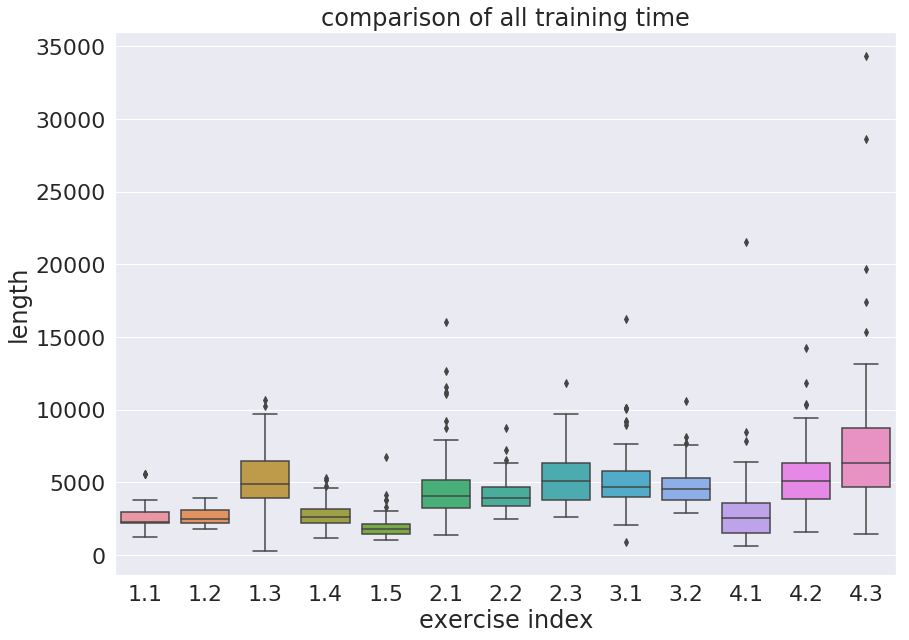

In [6]:
df_len_by_exc_num = df_without_empty[['exc_num', 'length']]

sns.set_style('whitegrid')
sns.set(font_scale=2)
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.boxplot(x="exc_num", y="length", data=df_len_by_exc_num)
ax.set_title('comparison of all training time')
ax.set(xlabel='exercise index')

 comparison of training time by each person

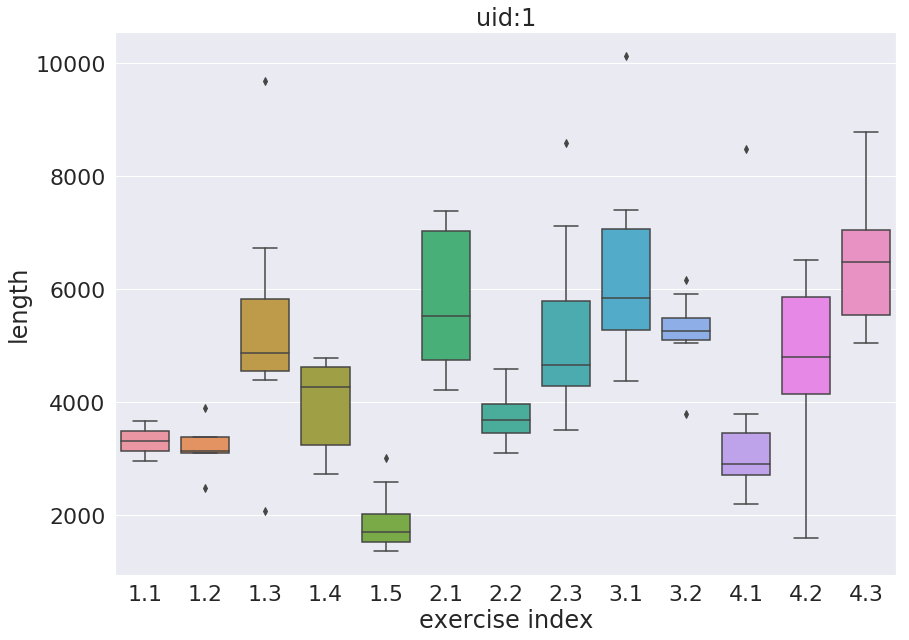

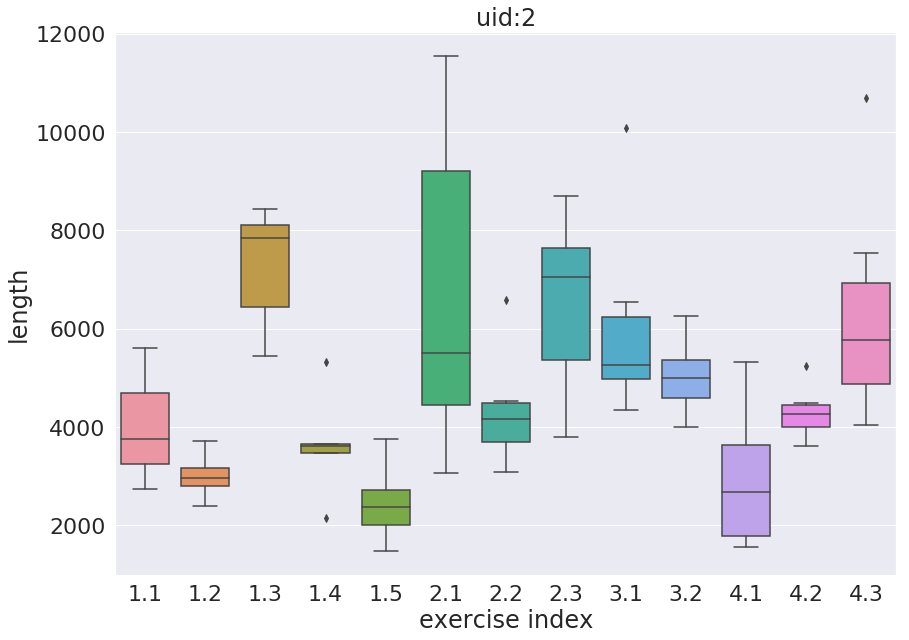

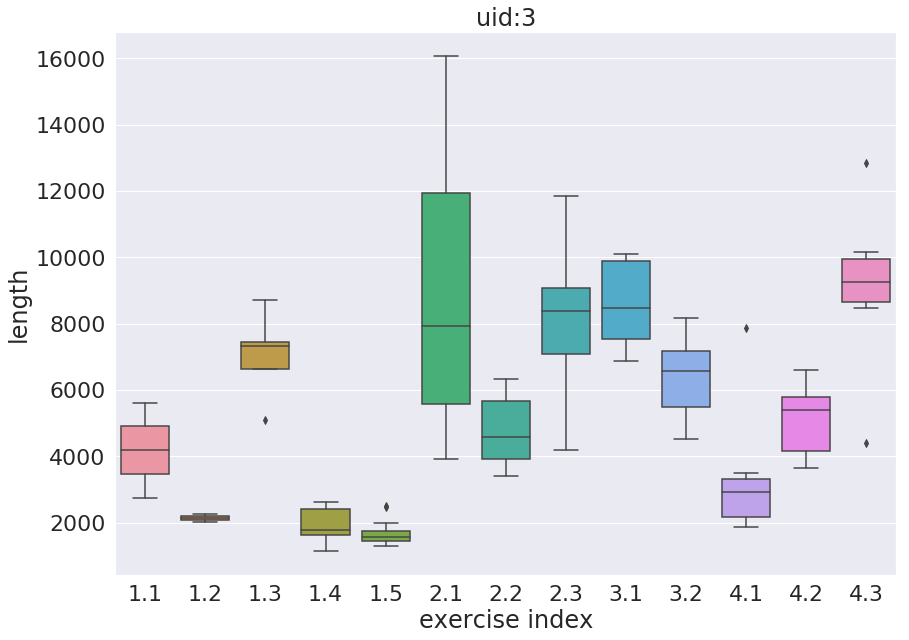

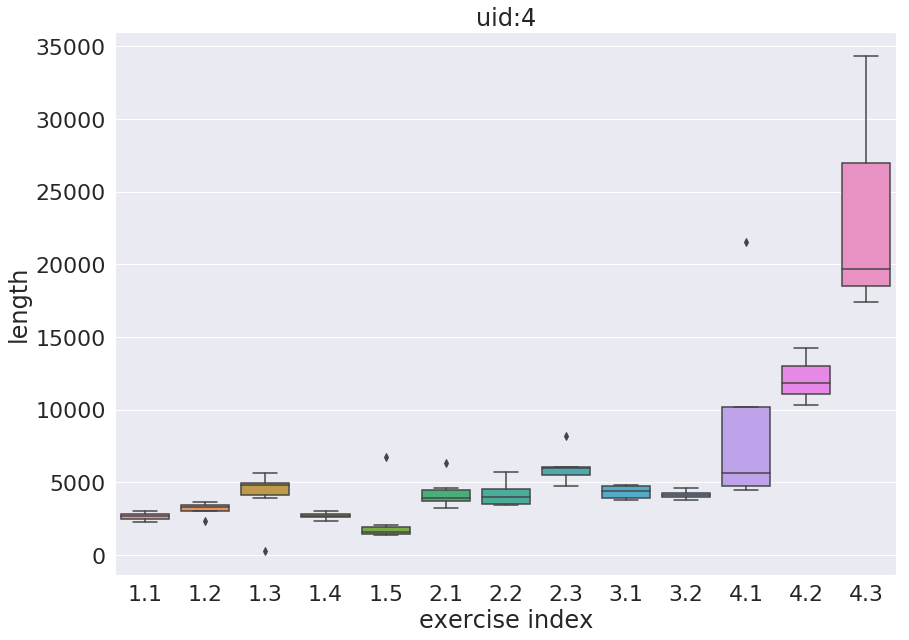

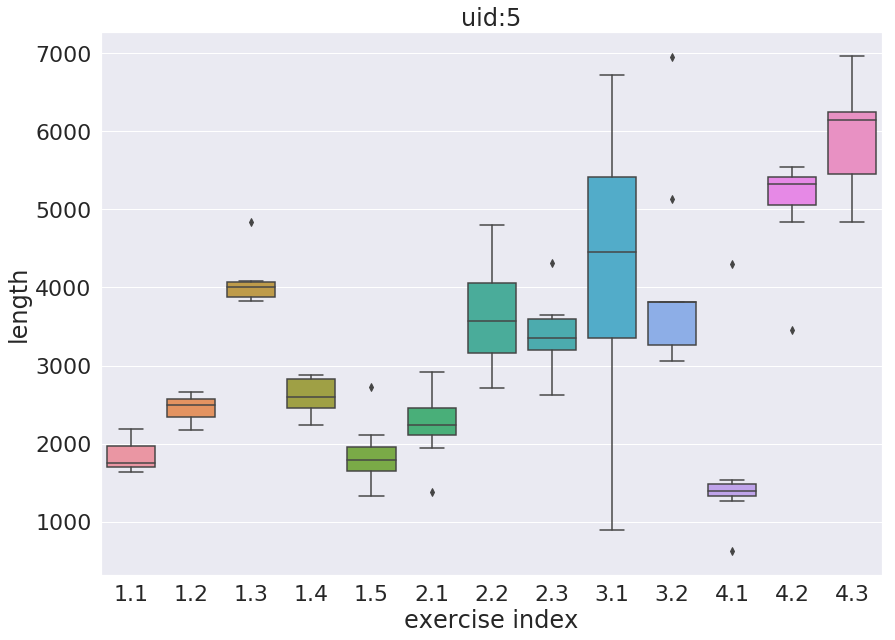

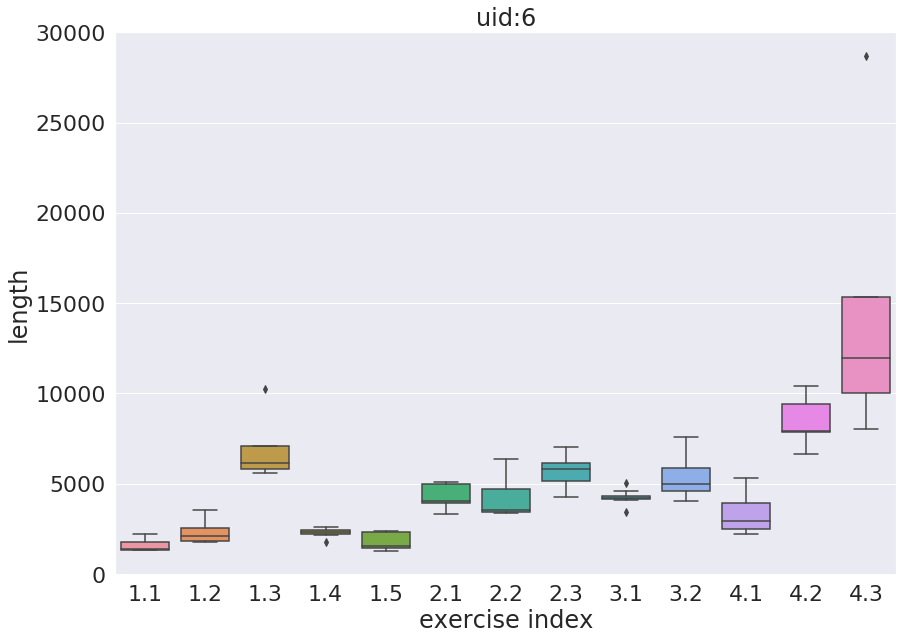

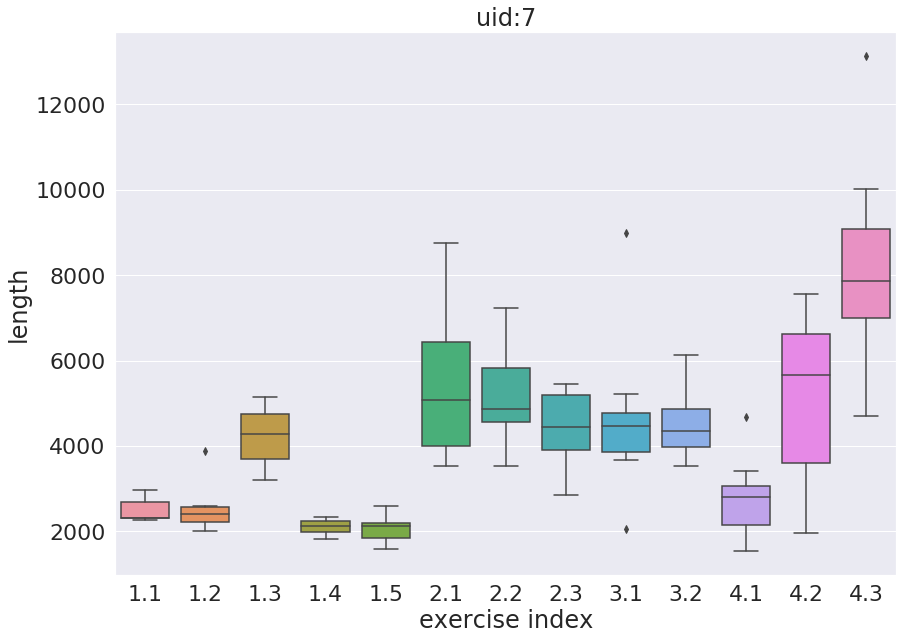

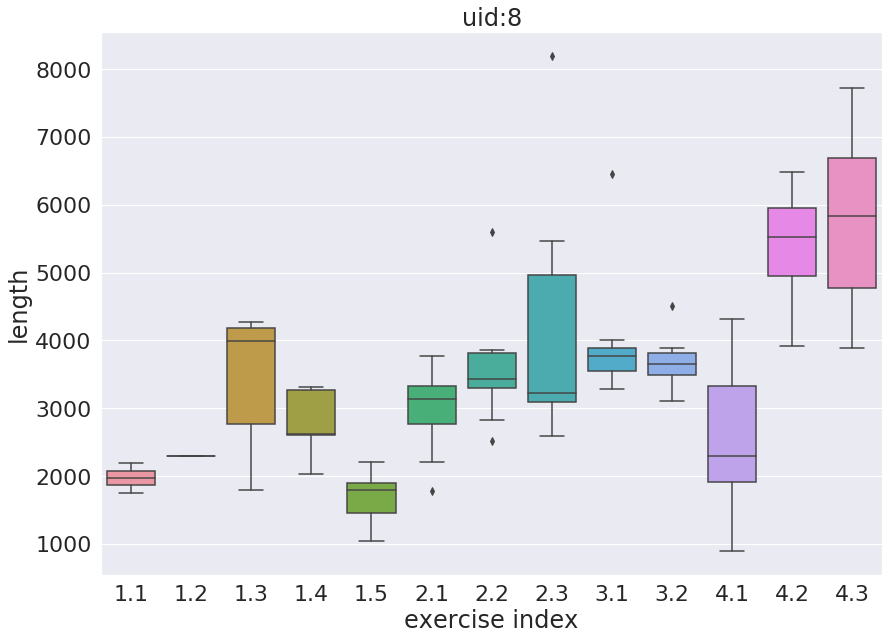

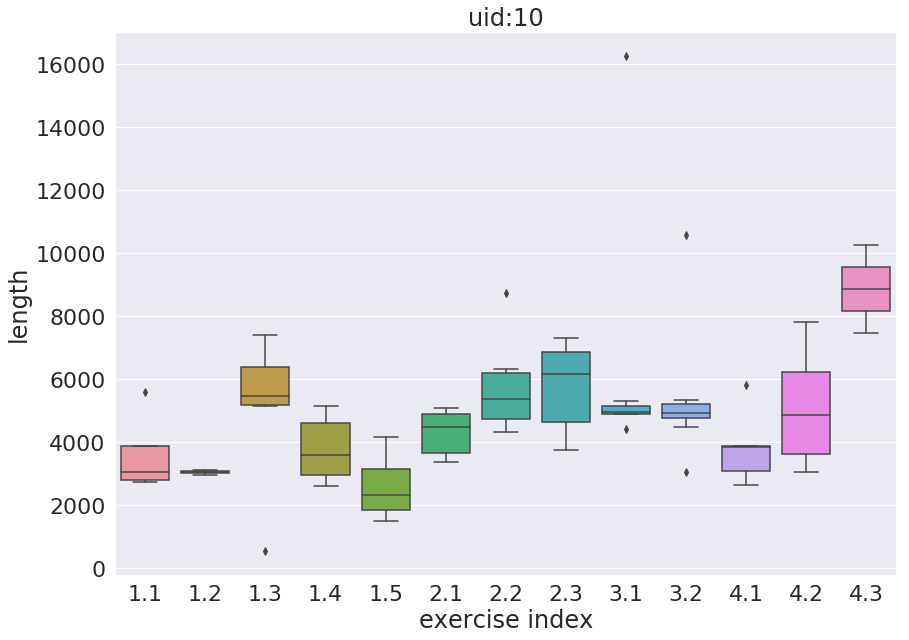

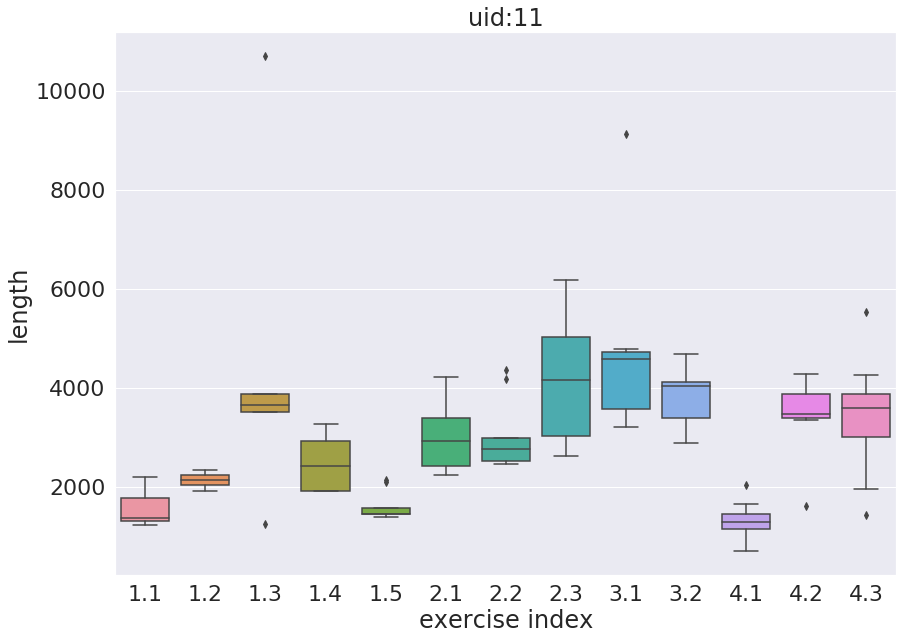

In [7]:
data = df_without_empty[['uid', 'exc_num', 'length']]
people = df_without_empty['uid'].unique().tolist()
for person in people:
    
    sns.set_style('whitegrid')
    sns.set(font_scale=2)
    f, ax= plt.subplots(figsize = (14, 10))
    tmp = df_without_empty[df_without_empty['uid']==person]
    ax = sns.boxplot(x="exc_num", y="length", data=tmp)
    ax.set_title('uid:'+str(person))
    ax.set(xlabel='exercise index')

### 2.2 score1 data

delete empty data

In [8]:
df_score1 = evaluation_method1(df)
df_score1 = df_score1.reset_index()
df_score1.columns

df_without_empty = df_without_empty.set_index(['day', 'exc_num', 'exc_times', 'uid'])
df_score1 = df_score1.set_index(['day', 'exc_num', 'exc_times', 'uid'])
df_score1 = pd.concat([df_without_empty, df_score1], axis=1, join='inner')
df_without_empty = df_without_empty.reset_index()
df_score1 = df_score1.reset_index()
df_score1.head()

,day,exc_num,exc_times,uid,length,score
0,1,1.1,1,1,3667,6.354035
1,1,1.1,1,2,5614,12.358756
2,1,1.1,1,3,5614,38.855181
3,1,1.1,1,4,3068,11.133204
4,1,1.1,1,5,2187,33.594028


comparison of score1 over all participant

[Text(0.5,0,'exercise index')]

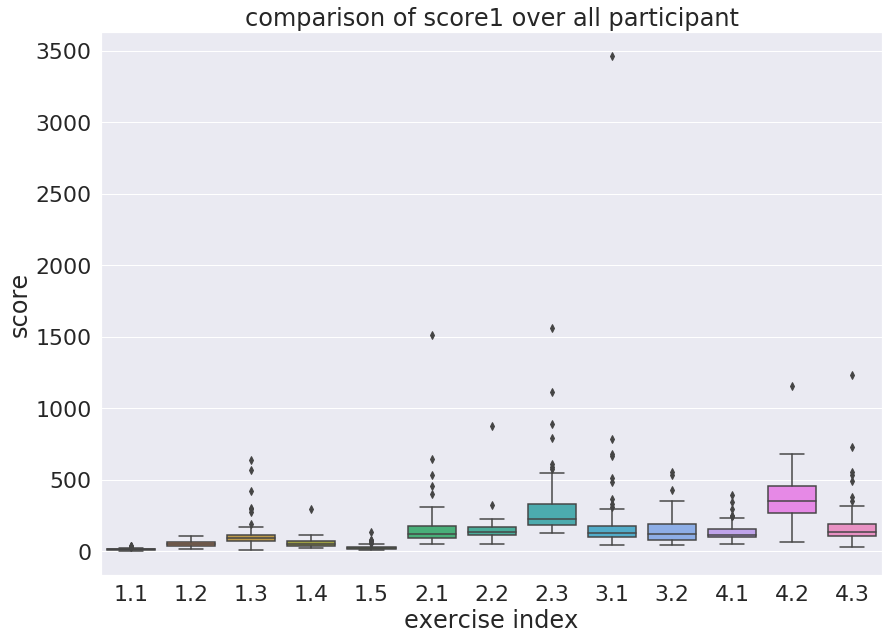

In [9]:
df_score1_by_exc_num = df_score1[['exc_num', 'score']]

sns.set_style('whitegrid')
sns.set(font_scale=2)
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.boxplot(x="exc_num", y="score", data=df_score1_by_exc_num)
ax.set_title('comparison of score1 over all participant')
ax.set(xlabel='exercise index')

comparison of training time by each person

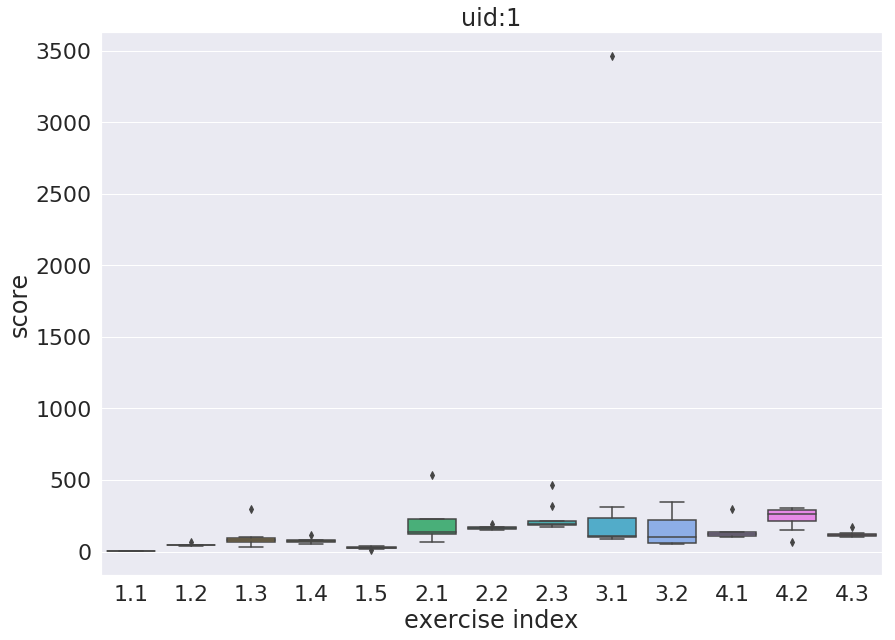

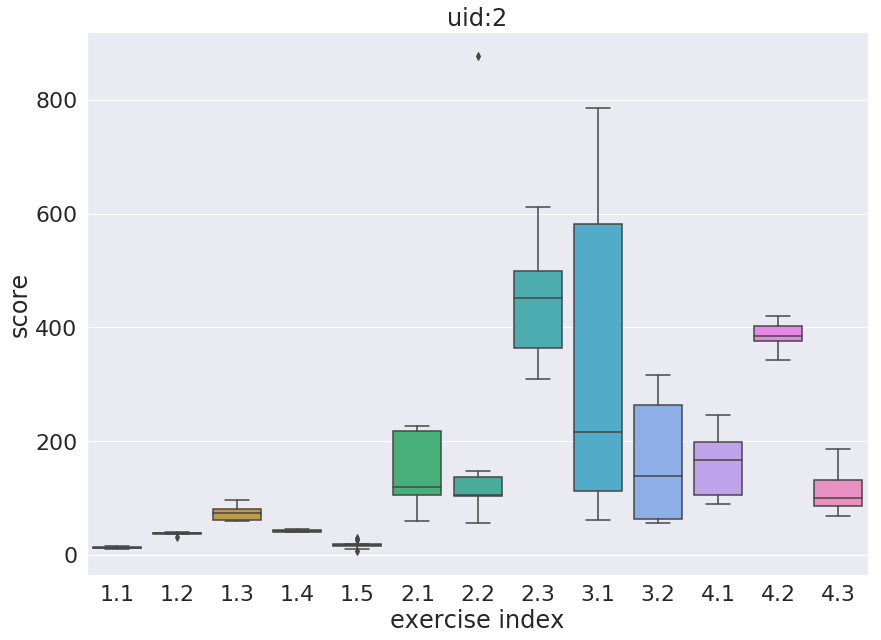

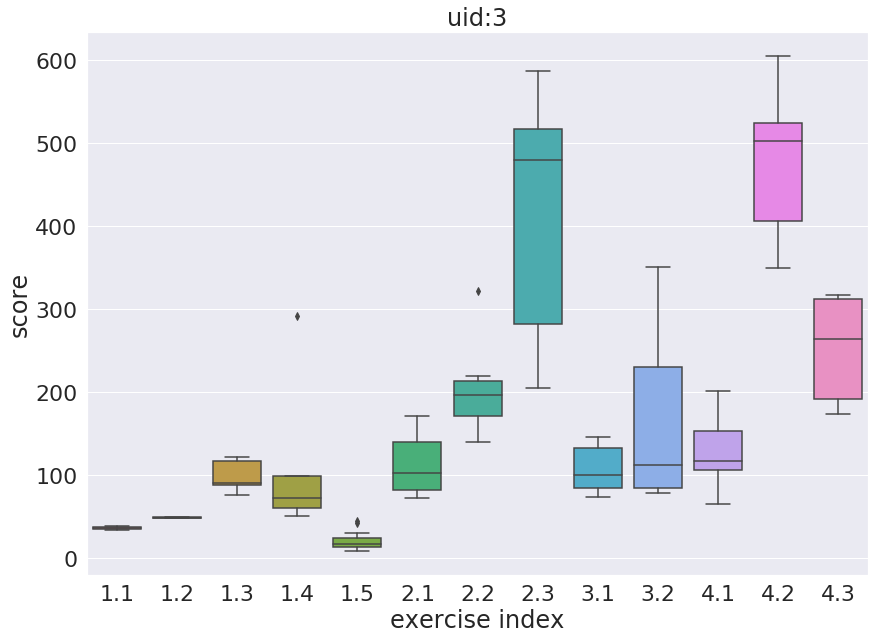

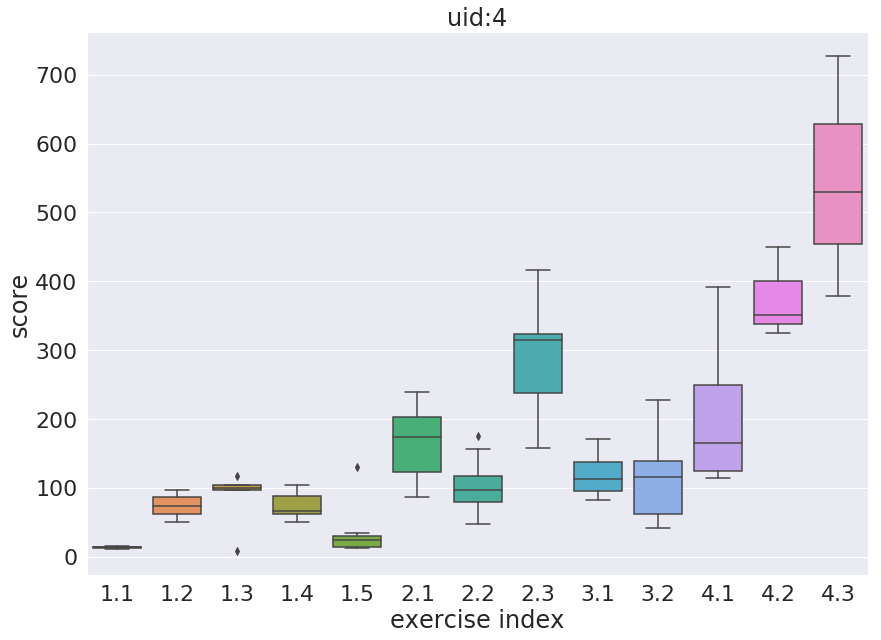

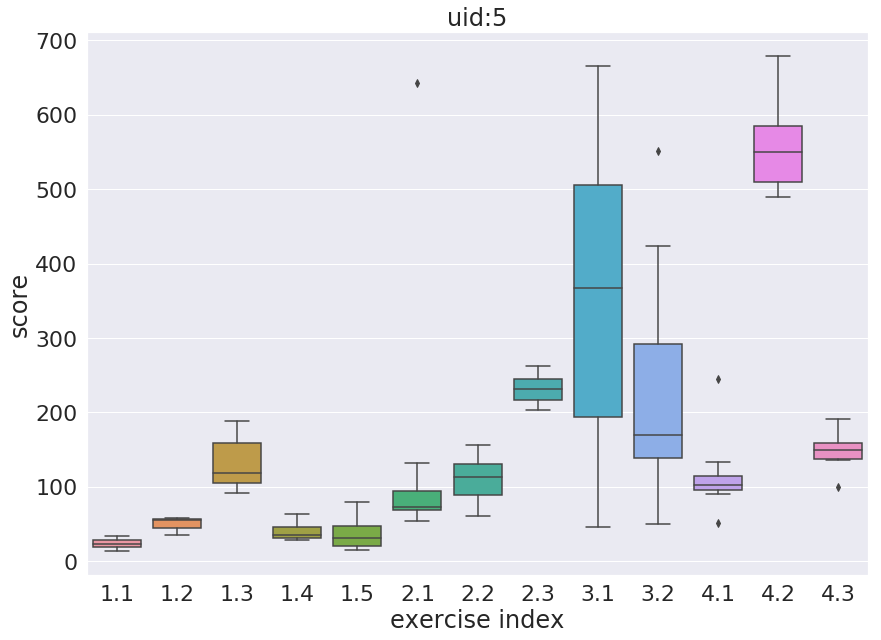

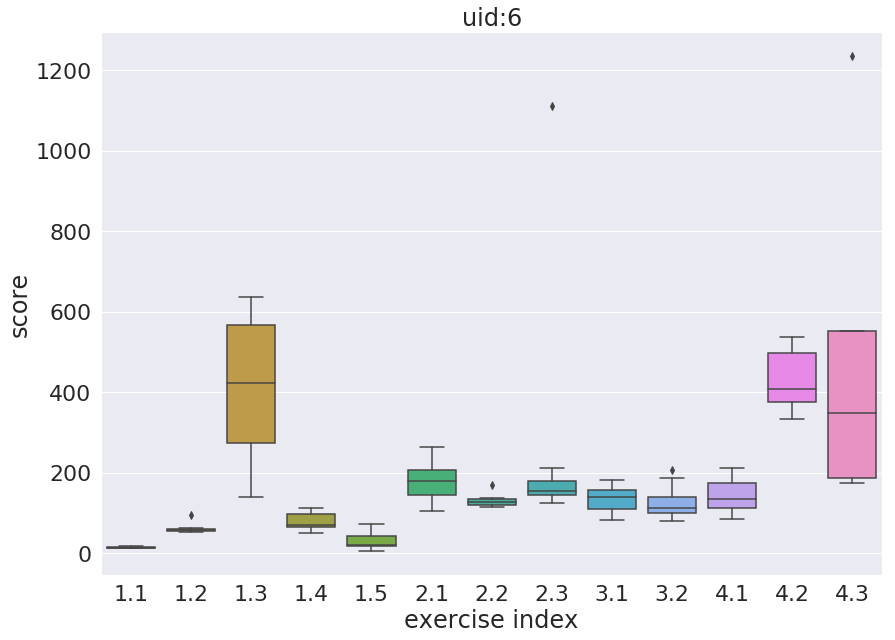

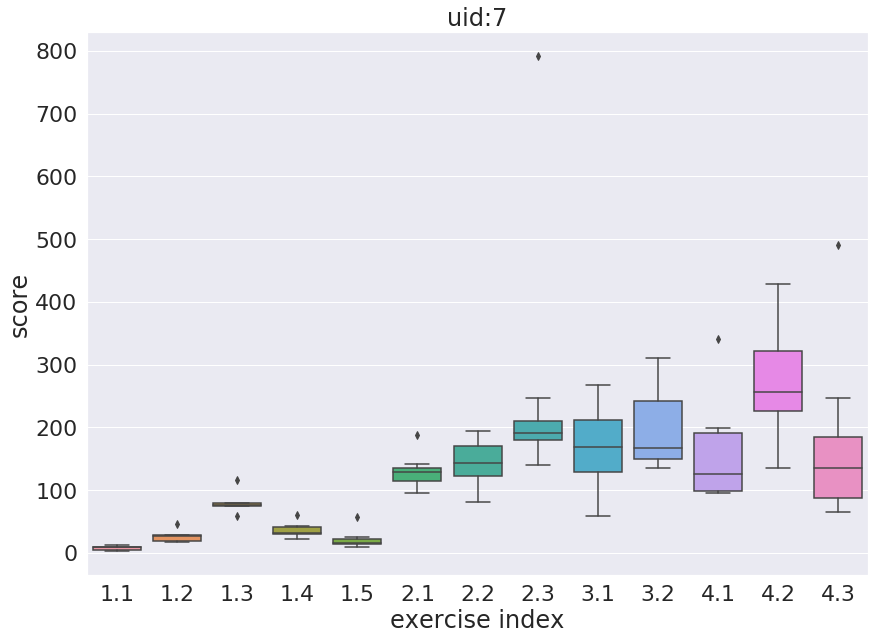

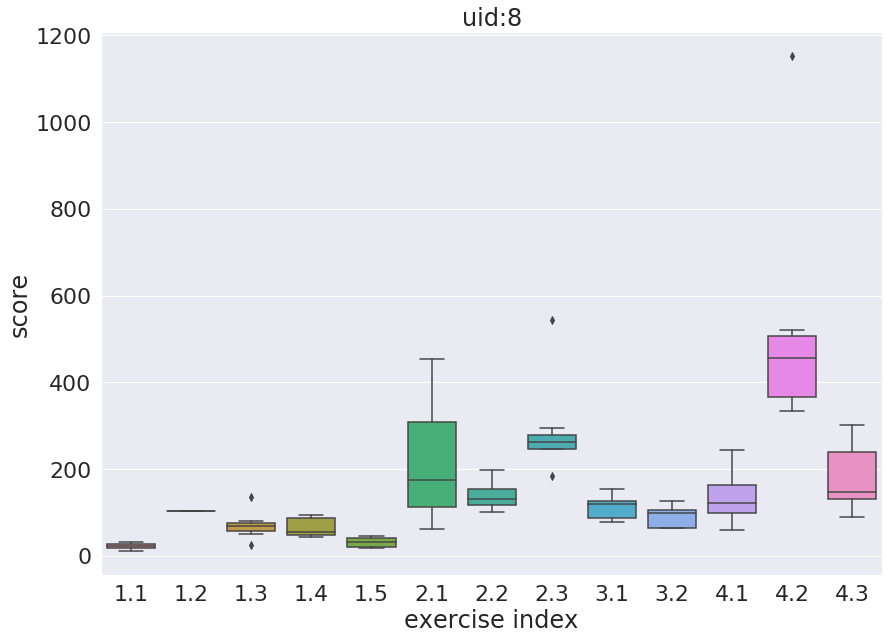

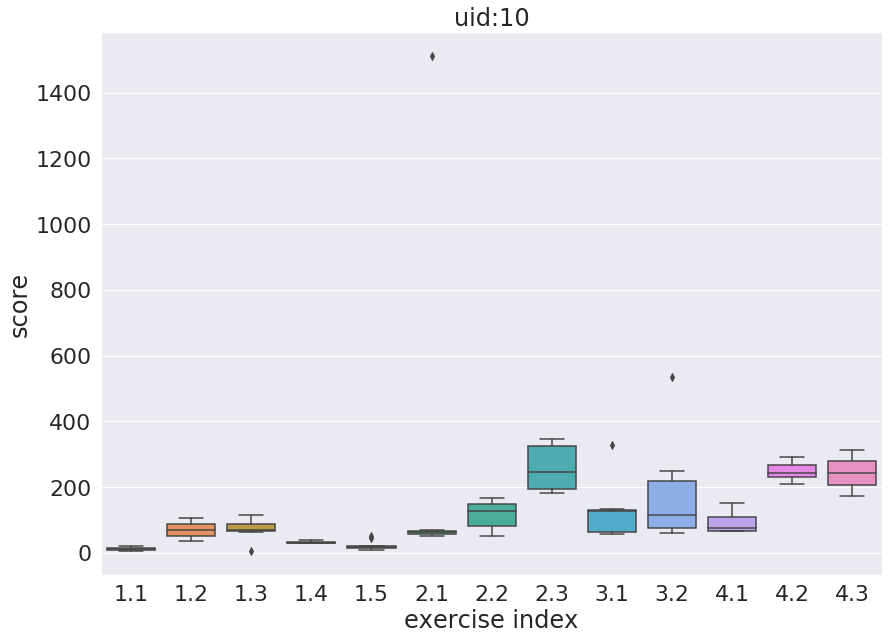

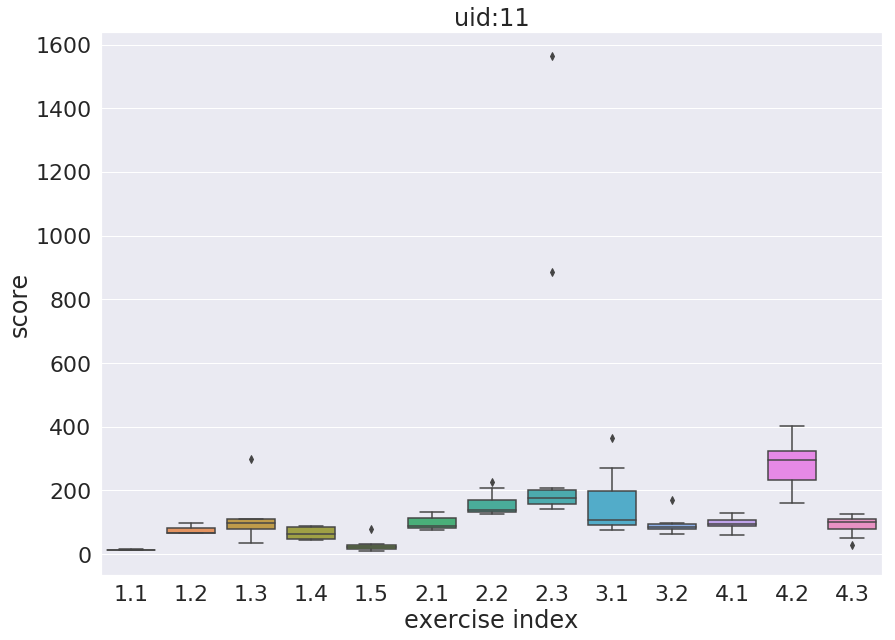

In [10]:
data = df_score1[['uid', 'exc_num', 'score']]
people = df_score1['uid'].unique().tolist()
for person in people:
    
    sns.set_style('whitegrid')
    sns.set(font_scale=2)
    f, ax= plt.subplots(figsize = (14, 10))
    tmp = df_score1[df_score1['uid']==person]
    ax = sns.boxplot(x="exc_num", y="score", data=tmp)
    ax.set_title('uid:'+str(person))
    ax.set(xlabel='exercise index')

# 3. Clean outlier

### 3.1 clean outlier according to length

initialize 

In [11]:
data = df_without_empty[['uid', 'exc_num', 'length', 'day', 'exc_times']]
people = df_without_empty['uid'].unique().tolist()
exc = df_without_empty['exc_num'].unique().tolist()
data = data.set_index(['exc_num'])

check ineffective data under all data 

In [12]:
grouped = data.groupby(by=data.index)
tmp = pd.DataFrame()

for index, group in grouped:
#     clf = EllipticEnvelope(contamination=0.1)
#     clf.fit(data.loc[index,'length'].as_matrix().reshape(-1, 1))
#     mask = clf.predict(data.loc[index,'length'].as_matrix().reshape(-1, 1))
#     group['global_length'] = mask
    group = clean_data(data, group, 'length', 'global_length', index)
    tmp = pd.concat([tmp, group])
    
data = tmp
tmp.head() 

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,uid,length,day,exc_times,global_length
exc_num,,,,,
1.1,1,3667,1,1,1
1.1,1,2955,1,2,1
1.1,2,5614,1,1,-1
1.1,2,2742,1,2,1
1.1,2,3763,1,3,1


check ineffective data under each user data 

In [13]:
tmp = pd.DataFrame()
for person in people: 
    tmp_person = data[data['uid']==person]
    grouped = tmp_person.groupby(tmp_person.index)
    

    for index, group in grouped:
#         clf = EllipticEnvelope(contamination=0.1)
#         if len(group)==1:
#             group['user_mask_length'] = 1
#         else:
#             clf.fit(tmp_person.loc[index,'length'].as_matrix().reshape(-1, 1))
#             mask = clf.predict(tmp_person.loc[index,'length'].as_matrix().reshape(-1, 1))
#             group['user_mask_length'] = mask
            
        group = clean_data(tmp_person, group, 'length', 'user_mask_length', index)
        tmp = pd.concat([tmp, group])

data_length = tmp
tmp.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,uid,length,day,exc_times,global_length,user_mask_length
exc_num,,,,,,
1.1,1,3667,1,1,1,1
1.1,1,2955,1,2,1,1
1.2,1,3903,1,1,-1,1
1.2,1,3143,1,2,1,1
1.2,1,3383,1,3,1,1


### 3.2 clean outlier according to score1 (oliver)

init

In [14]:
data = df_score1
data.columns

Index(['day', 'exc_num', 'exc_times', 'uid', 'length', 'score'], dtype='object')

check ineffective data under all data 

In [15]:
exc = data['exc_num'].unique().tolist()
data = data.set_index(['exc_num'])

grouped = data.groupby(by=data.index)
tmp = pd.DataFrame()

for index, group in grouped:
#     clf = EllipticEnvelope(contamination=0.1)
#     clf.fit(data.loc[index,'score'].as_matrix().reshape(-1, 1))
#     mask = clf.predict(data.loc[index,'score'].as_matrix().reshape(-1, 1))
#     group['global_score1'] = mask
    group = clean_data(data, group, 'score', 'global_score1', index)
    tmp = pd.concat([tmp, group])
    
data = tmp
tmp.head()  

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


,day,exc_times,uid,length,score,global_score1
exc_num,,,,,,
1.1,1,1,1,3667,6.354035,1
1.1,1,1,2,5614,12.358756,1
1.1,1,1,3,5614,38.855181,-1
1.1,1,1,4,3068,11.133204,1
1.1,1,1,5,2187,33.594028,-1


check ineffective data under each user data  

In [16]:
people = data['uid'].unique().tolist()

tmp = pd.DataFrame()
for person in people: 
    tmp_person = data[data['uid']==person]
    grouped = tmp_person.groupby(tmp_person.index)
    

    for index, group in grouped:
#         clf = EllipticEnvelope(contamination=0.1)
#         if len(group)==1:
#             group['user_mask_score1'] = 1
#         else:
#             clf.fit(tmp_person.loc[index,'score'].as_matrix().reshape(-1, 1))
#             mask = clf.predict(tmp_person.loc[index,'score'].as_matrix().reshape(-1, 1))
#             group['user_mask_score1'] = mask
        group = clean_data(tmp_person, group, 'score', 'user_mask_score1', index)
        tmp = pd.concat([tmp, group])

data_score1 = tmp
tmp.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  # This is added back by InteractiveShellApp.init_path()
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,day,exc_times,uid,length,score,global_score1,user_mask_score1
exc_num,,,,,,,
1.1,1,1,1,3667,6.354035,1,-1
1.1,1,2,1,2955,6.829834,1,1
1.2,1,1,1,3903,43.530778,1,1
1.2,1,2,1,3143,67.211988,1,-1
1.2,1,3,1,3383,46.351238,1,1


# 4. Observe data after cleaning 

### 4.1 length data

initialize data 

In [17]:
global_cleaned_data = data_length[data_length['global_length']>0]
user_cleaned_data = data_length[data_length['user_mask_length']>0]

comparison of all training time (length of each exercise file)  

[Text(0.5,0,'exercise index')]

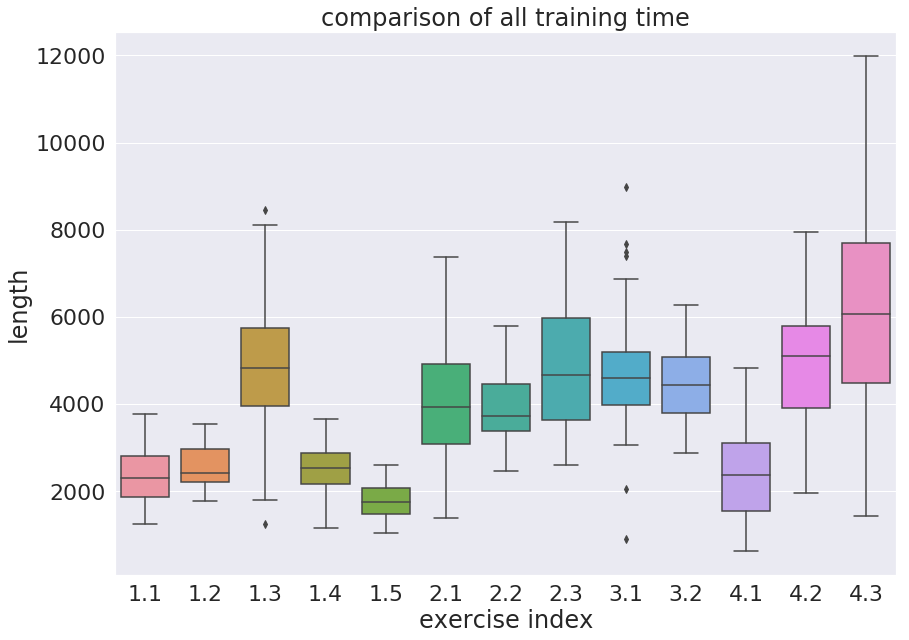

In [18]:
df_len_by_exc_num = global_cleaned_data.reset_index()[['exc_num', 'length']]

sns.set_style('whitegrid')
sns.set(font_scale=2)
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.boxplot(x="exc_num", y="length", data=df_len_by_exc_num)
ax.set_title('comparison of all training time')
ax.set(xlabel='exercise index')

comparison of training time by each person 

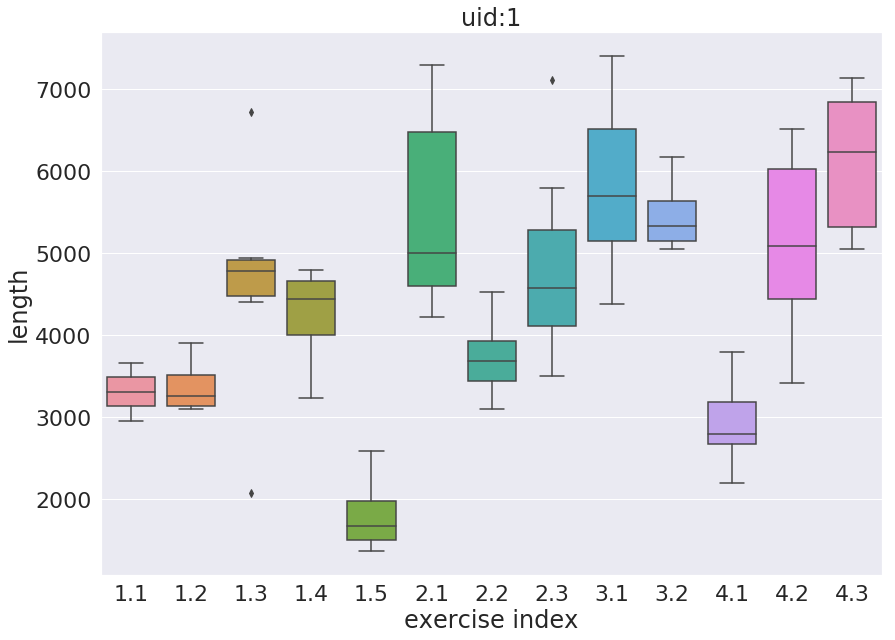

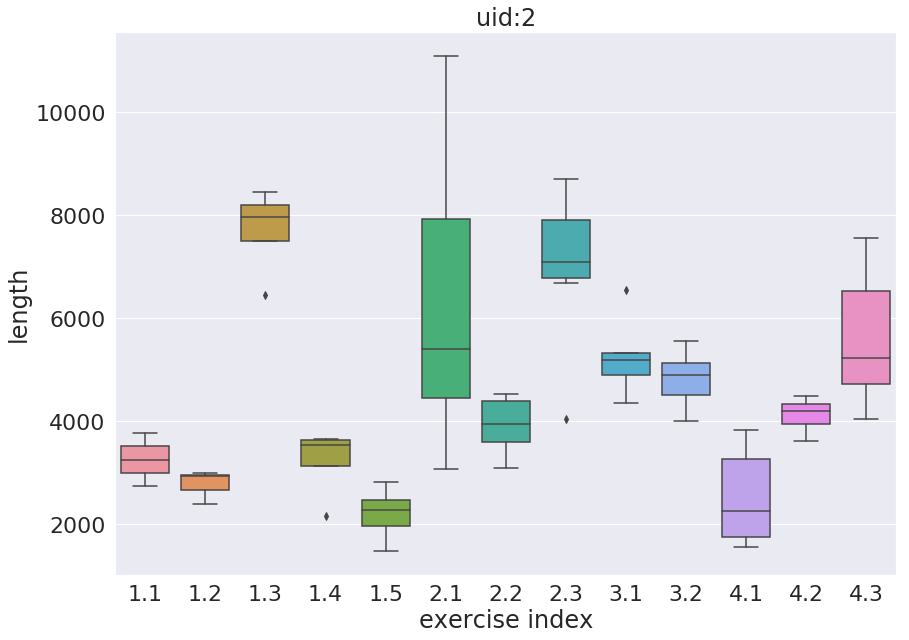

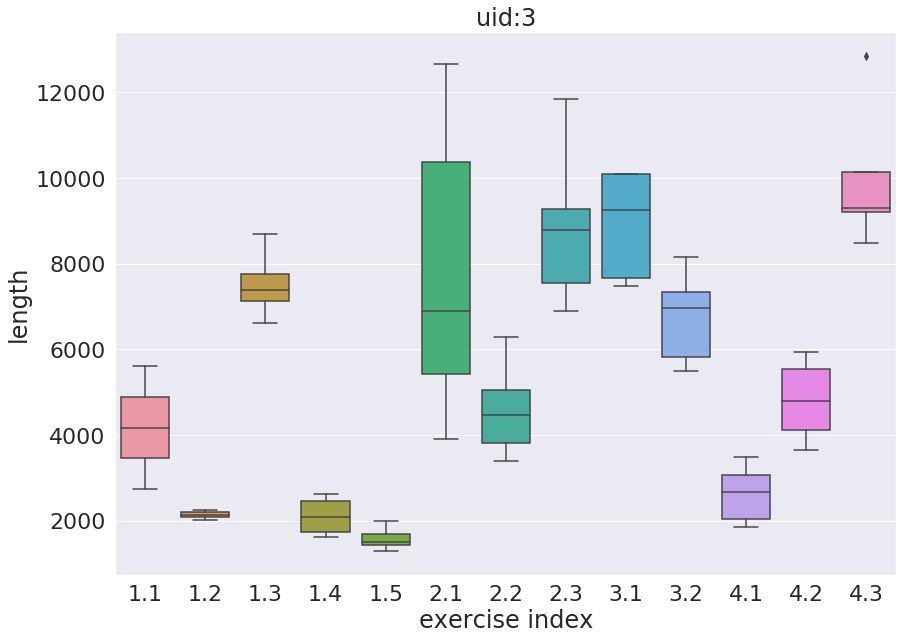

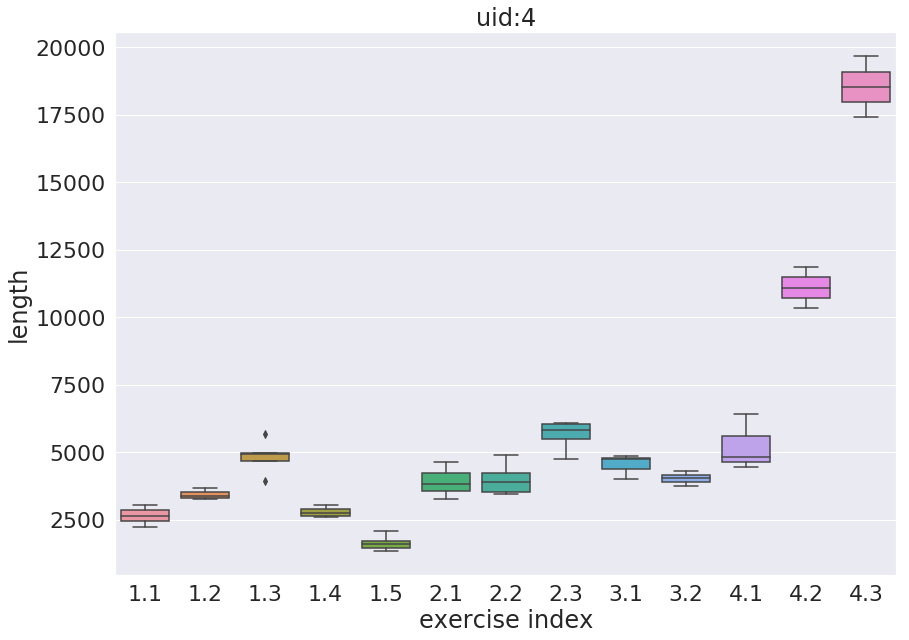

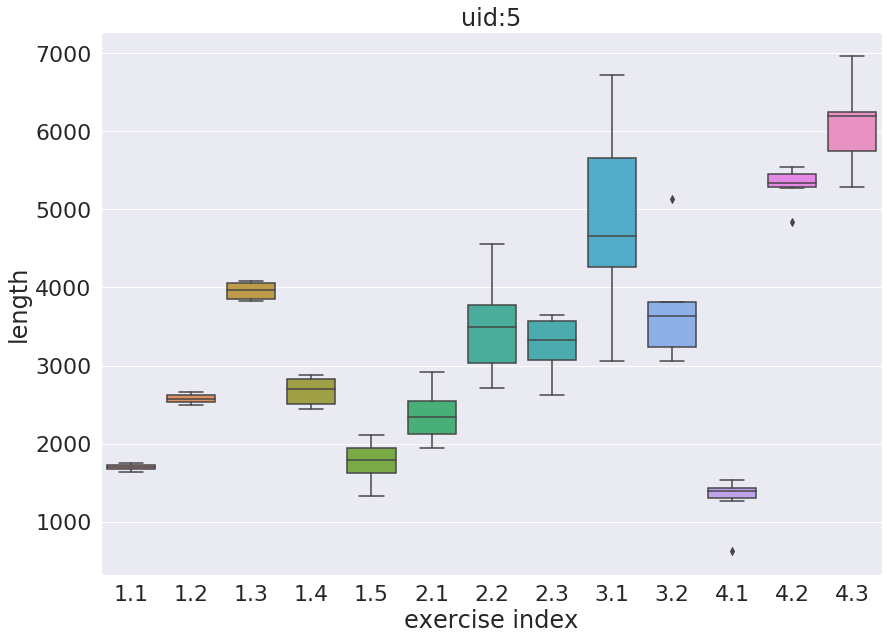

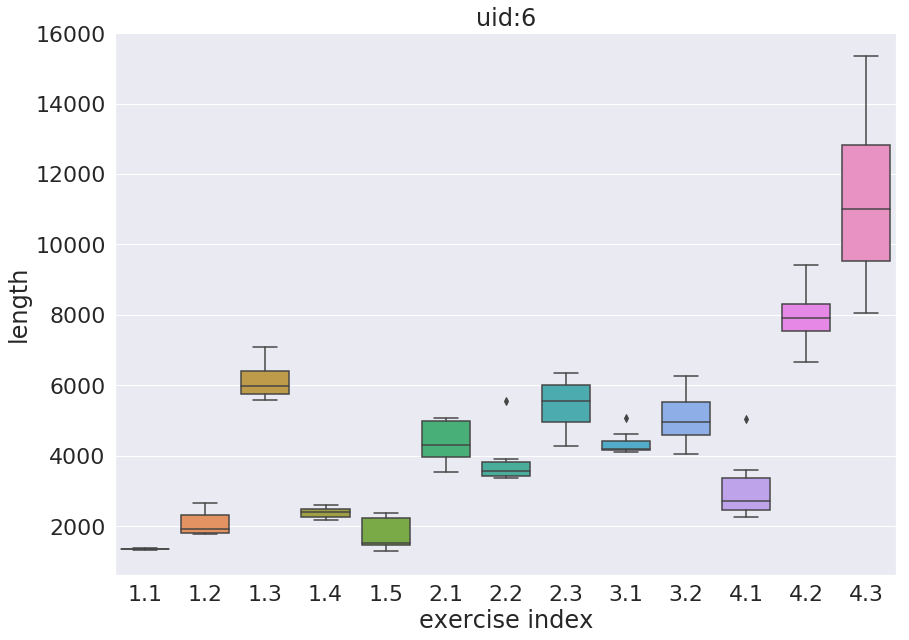

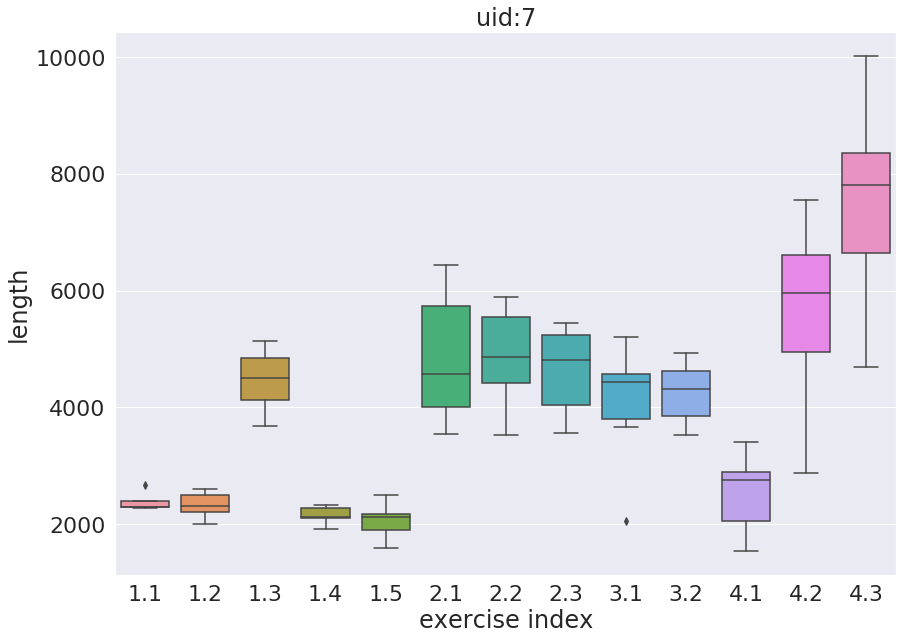

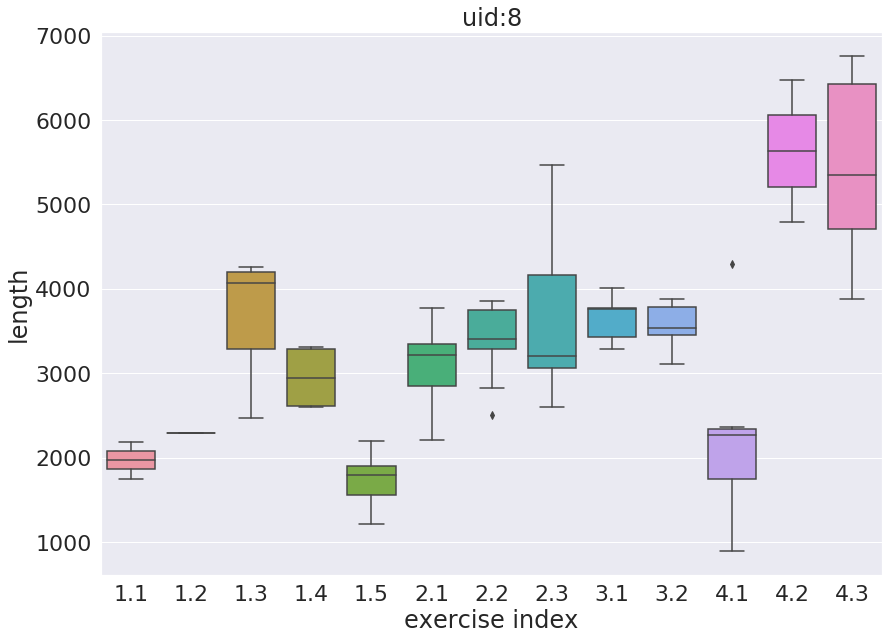

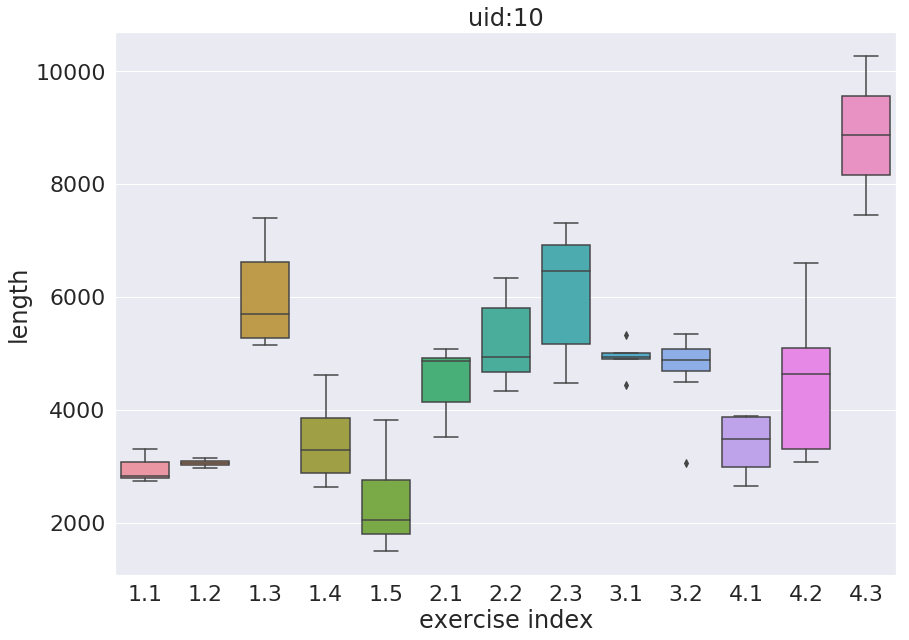

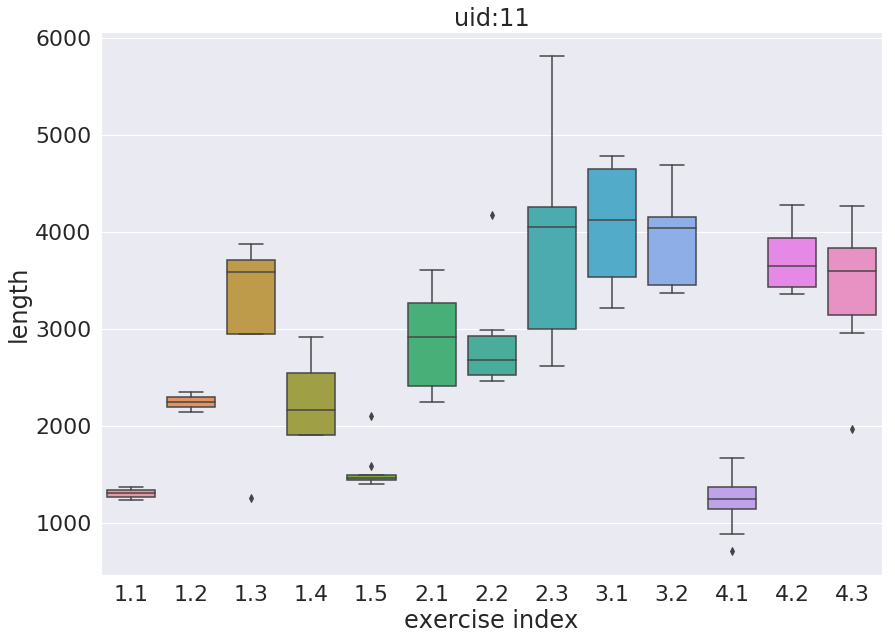

In [19]:
tmp_data = user_cleaned_data.reset_index()[['uid', 'exc_num', 'length']]
people = user_cleaned_data.reset_index()['uid'].unique().tolist()
for person in people:
    tmp = tmp_data[tmp_data['uid']==person]
    
    sns.set_style('whitegrid')
    sns.set(font_scale=2)
    f, ax= plt.subplots(figsize = (14, 10))
    
    ax = sns.boxplot(x="exc_num", y="length", data=tmp)
    ax.set_title('uid:'+str(person))
    ax.set(xlabel='exercise index')

In [20]:
index_without_outlier = user_cleaned_data.reset_index()
index_without_outlier.to_csv('../data/cleaned_index_length.csv', index=False)

### 4.2 score data

initialize data 

In [21]:
global_cleaned_data = data_score1[data_score1['global_score1']>0]
user_cleaned_data = data_score1[data_score1['user_mask_score1']>0]

 comparison of score over all paricipant

[Text(0.5,0,'exercise index')]

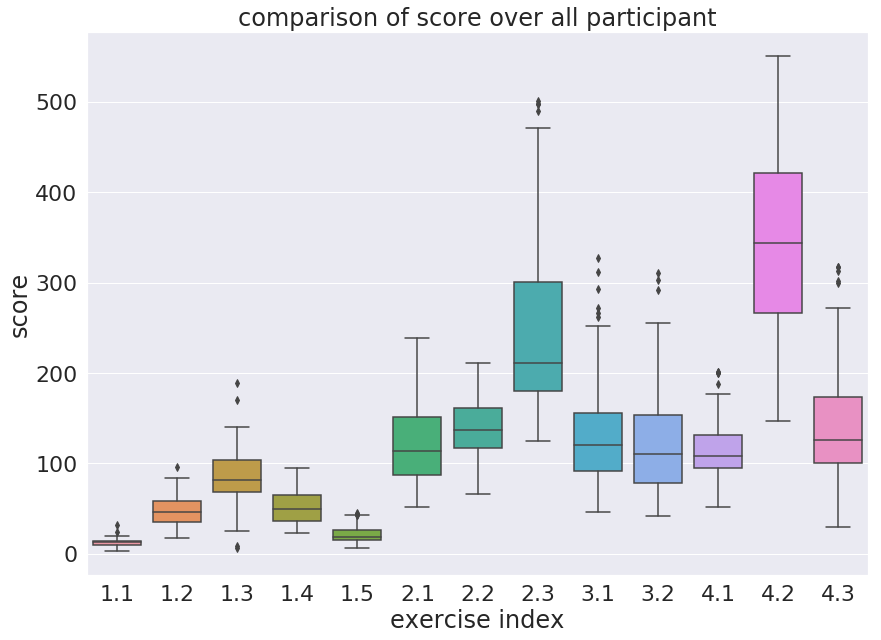

In [22]:
df_score1_by_exc_num = global_cleaned_data.reset_index()[['exc_num', 'score']]

sns.set_style('whitegrid')
sns.set(font_scale=2)
f, ax= plt.subplots(figsize = (14, 10))

ax = sns.boxplot(x="exc_num", y="score", data=df_score1_by_exc_num)
ax.set_title('comparison of score over all participant')
ax.set(xlabel='exercise index')

comparison of score by each person 

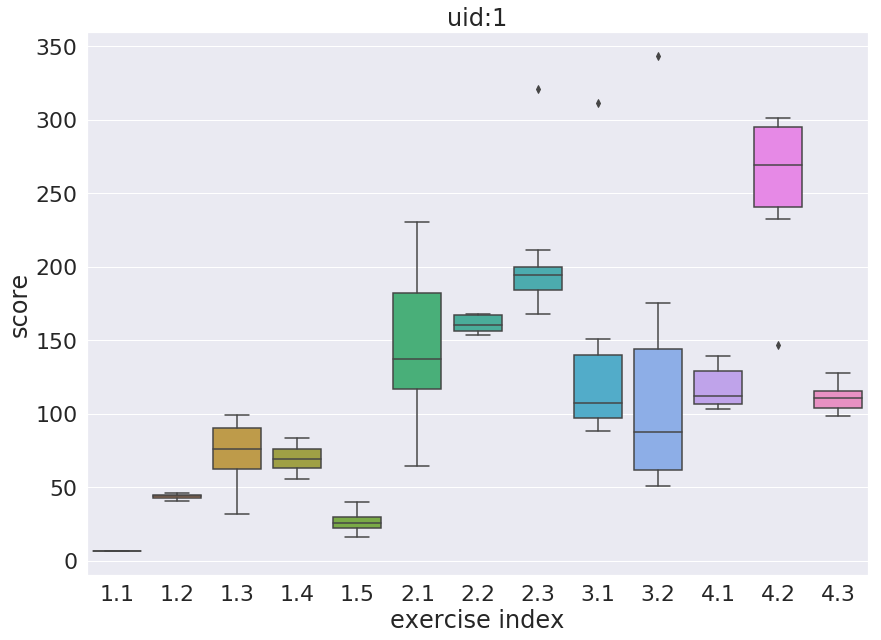

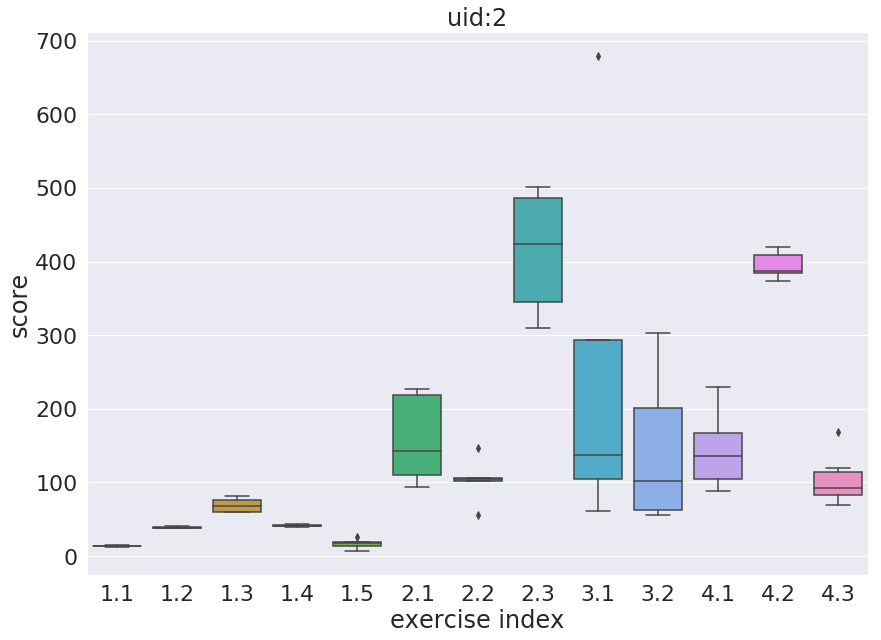

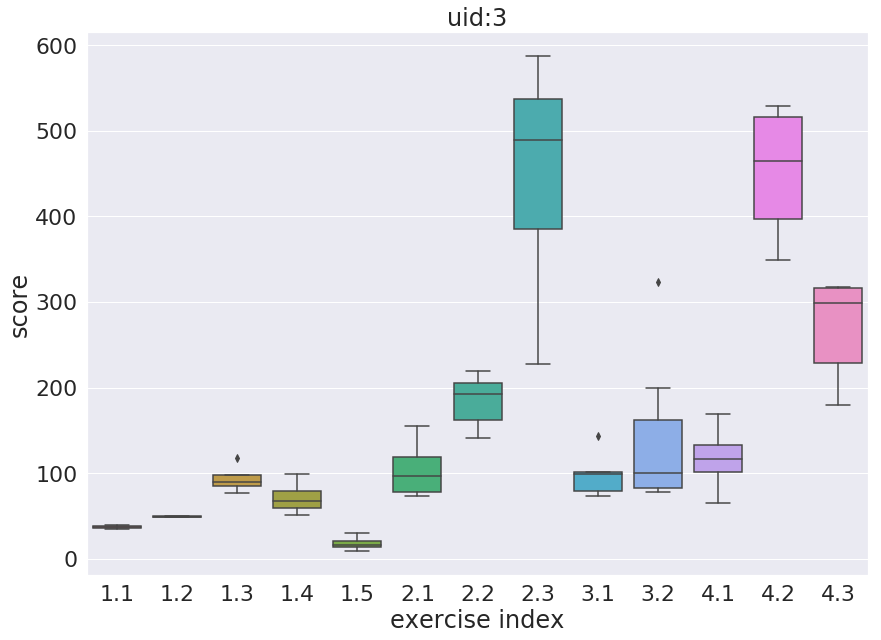

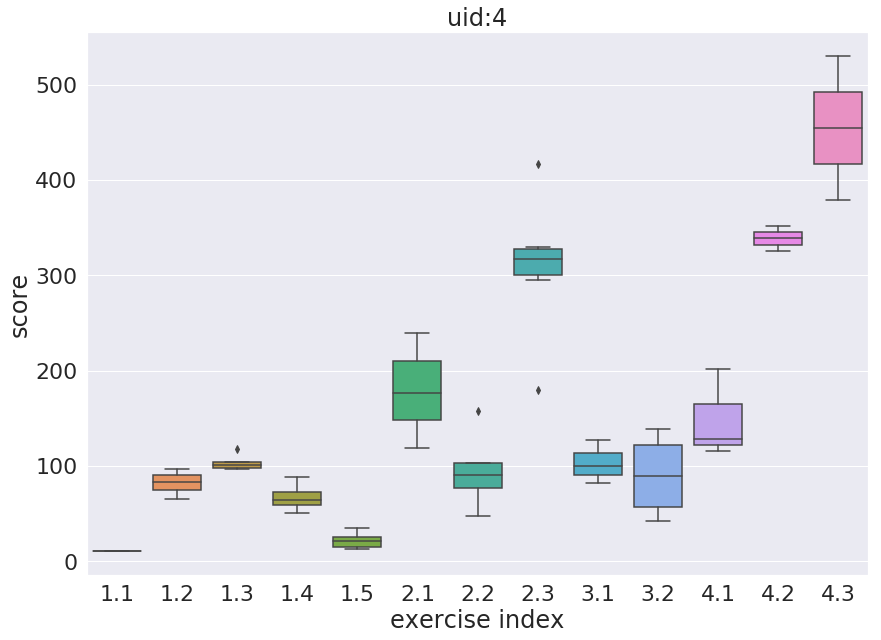

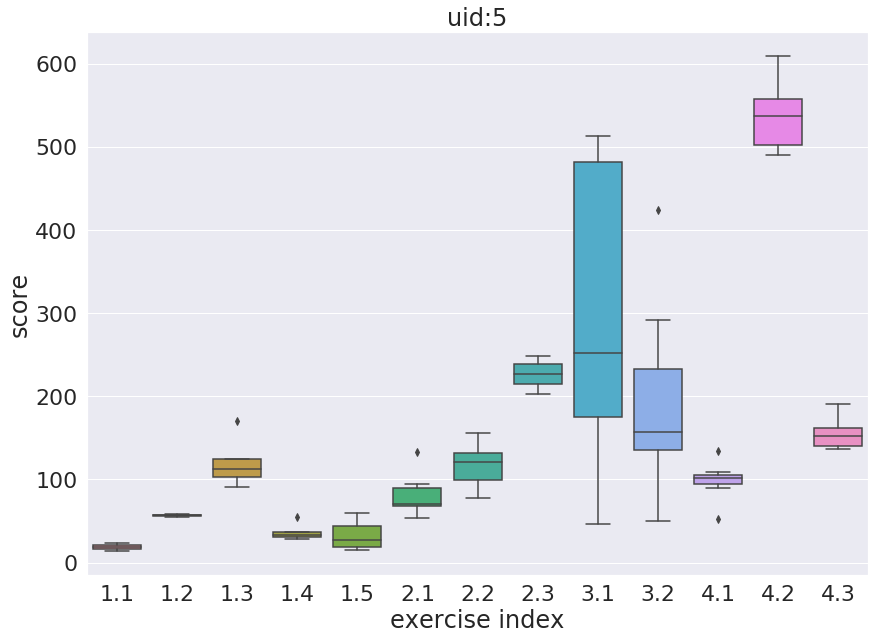

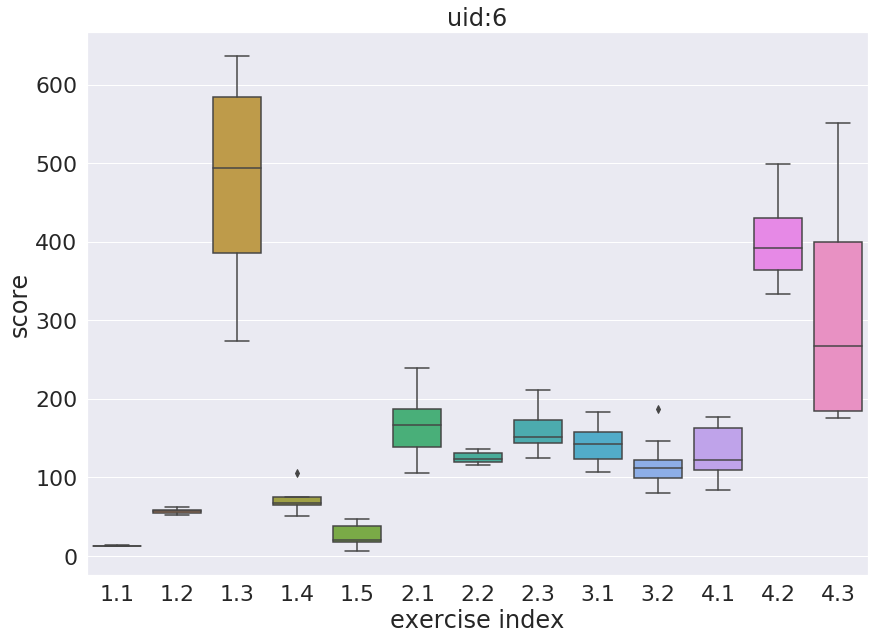

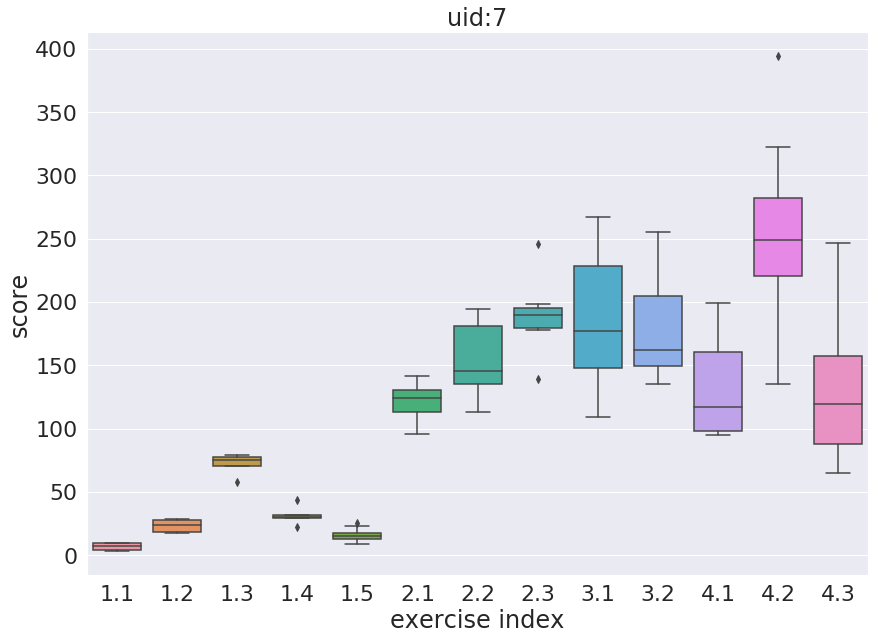

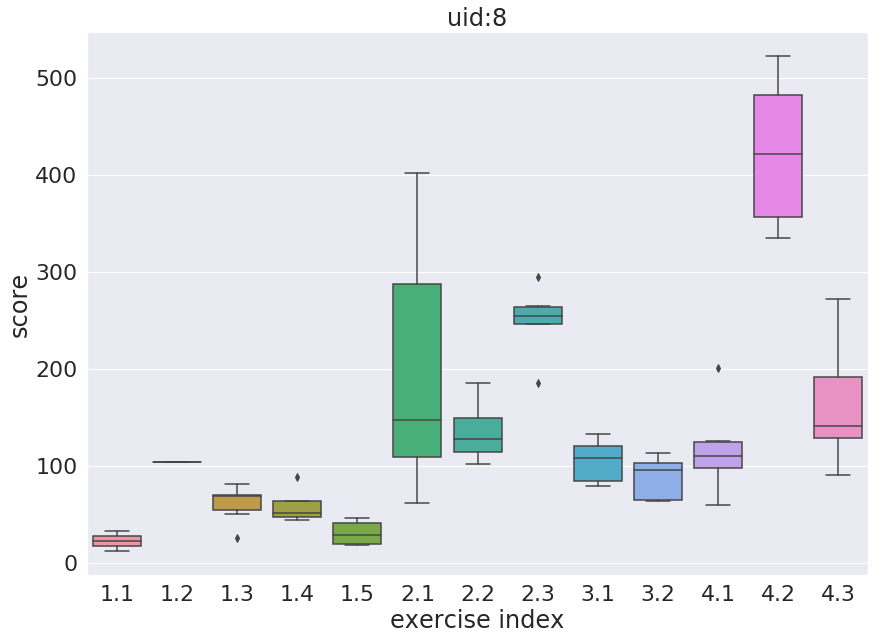

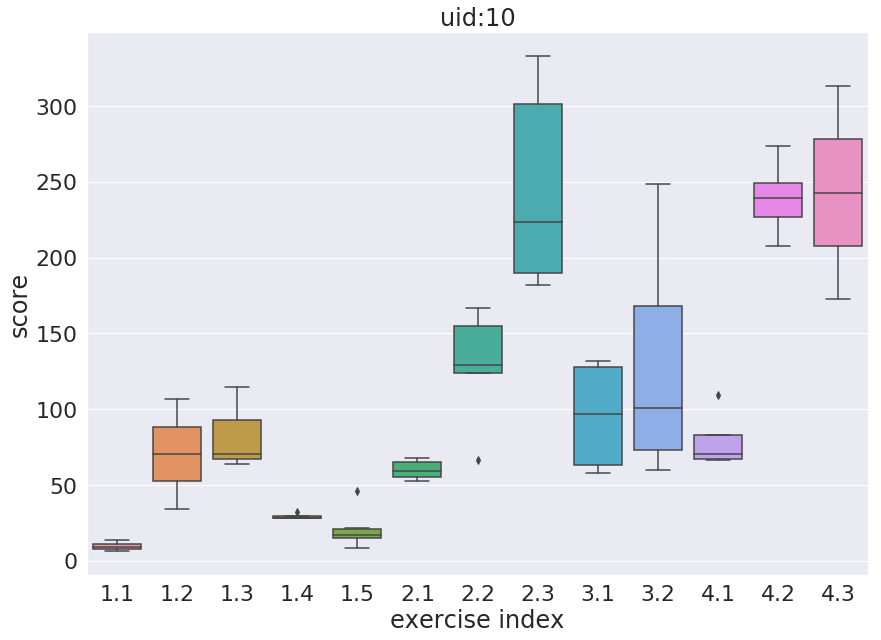

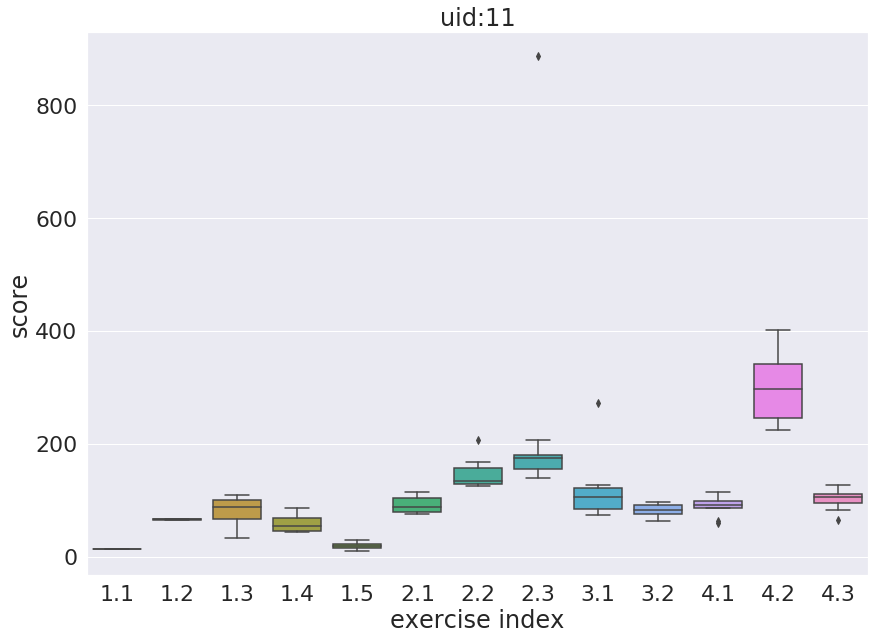

In [23]:
tmp_data = user_cleaned_data.reset_index()[['uid', 'exc_num', 'score']]
people = user_cleaned_data.reset_index()['uid'].unique().tolist()
for person in people:
    tmp = tmp_data[tmp_data['uid']==person]
    
    sns.set_style('whitegrid')
    sns.set(font_scale=2)
    f, ax= plt.subplots(figsize = (14, 10))
    
    ax = sns.boxplot(x="exc_num", y="score", data=tmp)
    ax.set_title('uid:'+str(person))
    ax.set(xlabel='exercise index')

In [24]:
index_without_outlier = user_cleaned_data.reset_index()
index_without_outlier.to_csv('../data/cleaned_index_score1.csv', index=False)